## Import Dependencies

In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import time

## tips
mode collapse:

Experimenting with the Learning Rate of both Generator and Discriminator helped me to overcome this problem.

## Configurable variables

In [2]:
NUM_EPOCHS = 50 #50 ;overtraining might degrade the quality of the generated samples
NOISE_DIMENSION = 128 #128 #256
BATCH_SIZE = 64  #128 ,use smaller than 64
TRAIN_ON_GPU = True

UNIQUE_RUN_ID = time.strftime("%Y-%m-%d--%H-%M-%S")
PRINT_STATS_AFTER_BATCH = 50
OPTIMIZER_LR = 0.0002
OPTIMIZER_BETAS = (0.5, 0.999)
GENERATOR_OUTPUT_IMAGE_SHAPE = 28 * 28 * 1

In [3]:
def get_device():
  """ Retrieve device based on settings and availability. """
  return torch.device("cuda:0" if torch.cuda.is_available() and TRAIN_ON_GPU else "cpu")

## Speed ups

In [4]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

## Prepare Dataset and Noise (functions):

In [5]:
def prepare_dataset():
  """ Prepare dataset through DataLoader """
  # Prepare MNIST dataset
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  # Batch and shuffle data with DataLoader
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
  # Return dataset through DataLoader
  return trainloader

In [6]:
def generate_noise(number_of_images = 1, noise_dimension = NOISE_DIMENSION, device=None):
  """ Generate noise for number_of_images images, with a specific noise_dimension """
  return torch.randn(number_of_images, noise_dimension, device=device)

## Models

### Generator_model

In [7]:
class Generator(nn.Module):
  """
    Vanilla GAN Generator
  """
  def __init__(self,):
    super().__init__()
    self.layers = nn.Sequential(
      # First upsampling
      nn.Linear(NOISE_DIMENSION, 128, bias=False),
      nn.BatchNorm1d(128, 0.8),
      nn.LeakyReLU(0.25),
      # Second upsampling
      nn.Linear(128, 256, bias=False),
      nn.BatchNorm1d(256, 0.8),
      nn.LeakyReLU(0.25),
      # Third upsampling
      nn.Linear(256, 512, bias=False),
      nn.BatchNorm1d(512, 0.8),
      nn.LeakyReLU(0.25),
      # Final upsampling
      nn.Linear(512, GENERATOR_OUTPUT_IMAGE_SHAPE, bias=False),
      nn.Tanh()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

### Discriminator_model

In [8]:
class Discriminator(nn.Module):
  """
    Vanilla GAN Discriminator
  """
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(GENERATOR_OUTPUT_IMAGE_SHAPE, 1024), 
      nn.LeakyReLU(0.25),
      nn.Linear(1024, 512), 
      nn.LeakyReLU(0.25),
      nn.Linear(512, 256), 
      nn.LeakyReLU(0.25),
      nn.Linear(256, 1),
      nn.Sigmoid() # will later delete this to solve vanishing gradient as well as mode collapse
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

## Train Functions

In [9]:
def efficient_zero_grad(model):
  """ 
    Apply zero_grad more efficiently
    Source: https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  """
  for param in model.parameters():
    param.grad = None
    


def forward_and_backward(model, data, loss_function, targets):
  """
    Perform forward and backward pass in a generic way. Returns loss value.
  """
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()  

In [10]:
def perform_train_step(generator, discriminator, real_data, \
  loss_function, generator_optimizer, discriminator_optimizer, device = get_device()):
  """ Perform a single training step. """
  
  # 1. PREPARATION
  # Set real and fake labels.
  real_label, fake_label = 1.0, 0.0
  # Get images on CPU or GPU as configured and available
  # Also set 'actual batch size', whih can be smaller than BATCH_SIZE
  # in some cases.
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  label = torch.full((actual_batch_size,1), real_label, device=device)
  
  # 2. TRAINING THE DISCRIMINATOR
  # Zero the gradients for discriminator
  efficient_zero_grad(discriminator)
  # Forward + backward on real images, reshaped
  real_images = real_images.view(real_images.size(0), -1)
  error_real_images = forward_and_backward(discriminator, real_images, \
    loss_function, label)
  # Forward + backward on generated images
  noise = generate_noise(actual_batch_size, device=device)
  generated_images = generator(noise)
  label.fill_(fake_label)
  error_generated_images =forward_and_backward(discriminator, \
    generated_images.detach(), loss_function, label)
  # Optim for discriminator
  discriminator_optimizer.step()
  
  # 3. TRAINING THE GENERATOR
  # Forward + backward + optim for generator, including zero grad
  efficient_zero_grad(generator)
  label.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, loss_function, label)
  generator_optimizer.step()
  
  # 4. COMPUTING RESULTS
  # Compute loss values in floats for discriminator, which is joint loss.
  error_discriminator = error_real_images + error_generated_images
  error_discriminator_real = error_real_images
  error_discriminator_fake = error_generated_images
  # Return generator and discriminator loss so that it can be printed.
  return error_generator, error_discriminator_real, error_discriminator_fake 

In [11]:
def print_training_progress(batch, generator_loss, discriminator_loss_real, discriminator_loss_fake, iteration_for_tensorboard):
  """ Print training progress. """
  print('%d iter; Losses after mini-batch %5d: generator %e, discriminator %e' %
        (iteration_for_tensorboard, batch, generator_loss, discriminator_loss_real + discriminator_loss_fake))

def print_on_tensorboard(writer, current_epoch, batch_no, generator_loss, discriminator_loss_real, discriminator_loss_fake, iteration_for_tensorboard):
    writer.add_scalars(f'loss/gan', {
    'G_loss': generator_loss,
    'D_loss_real': discriminator_loss_real,
    'D_loss_fake': discriminator_loss_fake,}, iteration_for_tensorboard)
#     print(iteration_for_tensorboard)
    iteration_for_tensorboard += 1
    return iteration_for_tensorboard
    
    
# generate image after couple of batches
def generate_image(generator, epoch = 0, batch = 0, device=get_device()):
  """ Generate subplots with generated examples. """
  images = []
  noise = generate_noise(BATCH_SIZE, device=device)
  generator.eval()
  images = generator(noise)
  plt.figure(figsize=(10, 10))
  for i in range(16):
    # Get image
    image = images[i]
    # Convert image back onto CPU and reshape
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    # Plot
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
  plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')



def save_models(generator, discriminator, epoch):
  """ Save models at specific point in time. """
  torch.save(generator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/generator_{epoch}.pth')
  torch.save(discriminator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/discriminator_{epoch}.pth')



def perform_epoch(writer, dataloader, generator, discriminator, loss_function, \
    generator_optimizer, discriminator_optimizer, epoch, iteration_for_tensorboard):
  """ Perform a single epoch. """
  for batch_no, real_data in enumerate(dataloader, 0):
    # Perform training step
    generator_loss_val, error_discriminator_real, error_discriminator_fake = perform_train_step(generator, \
      discriminator, real_data, loss_function, \
      generator_optimizer, discriminator_optimizer)
    # Print statistics and generate image after every n-th batch
    if batch_no % PRINT_STATS_AFTER_BATCH == 0:
      print_training_progress(batch_no, generator_loss_val, error_discriminator_real, error_discriminator_fake, iteration_for_tensorboard)
      generate_image(generator, epoch, batch_no)
      iteration_for_tensorboard = print_on_tensorboard(writer, epoch, batch_no, 
                                                       generator_loss_val, error_discriminator_real, error_discriminator_fake, 
                                                       iteration_for_tensorboard)
      
      
  # Save models on epoch completion.
  save_models(generator, discriminator, epoch)
  # Clear memory after every epoch
  torch.cuda.empty_cache()
  return iteration_for_tensorboard

## Run

In [12]:
def make_directory_for_run():
  """ Make a directory for this training run. """
  print(f'Preparing training run {UNIQUE_RUN_ID}')
  if not os.path.exists('./runs'):
    os.mkdir('./runs')
  os.mkdir(f'./runs/{UNIQUE_RUN_ID}')


def initialize_models(device = get_device()):
  """ Initialize Generator and Discriminator models """
  generator = Generator()
  discriminator = Discriminator()
  # Move models to specific device
  generator.to(device)
  discriminator.to(device)
  # Return models
  return generator, discriminator


def initialize_loss(): # binary_crossentropy; Wasserstein loss function will do better
  """ Initialize loss function. """
  return nn.BCELoss()


def initialize_optimizers(generator, discriminator):
  """ Initialize optimizers for Generator and Discriminator. """
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  return generator_optimizer, discriminator_optimizer

In [13]:
def load_models_weights(device = get_device()):
  generator = Generator()
  gen_wt = torch.load("generator.pth")
  generator.load_state_dict(gen_wt)

  discriminator = Discriminator()
  dis_wt = torch.load("discriminator.pth")
  discriminator.load_state_dict(dis_wt)
  # Move models to specific device
  generator.to(device)
  discriminator.to(device)
  return generator, discriminator

# generator_optimizer, discriminator_optimizer = load_optimizers_weight(generator, discriminator)

In [14]:
def train_dcgan(train_continue = False):
  """ Train the DCGAN. """
  # Make directory for unique run
  make_directory_for_run()
  # Set fixed random number seed
  torch.manual_seed(42)
  # Get prepared dataset
  dataloader = prepare_dataset()
  # Initialize models
  generator, discriminator = initialize_models()
  # Initialize loss and optimizers
  loss_function = initialize_loss()
  generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator)
  if train_continue:
    generator, discriminator = load_models_weights()
#     generator_optimizer, discriminator_optimizer = load_optimizers_weight(generator, discriminator)
  # Train the model
        # summarywriter
  writer = SummaryWriter()
  iteration_for_tensorboard = 1
  for epoch in range(NUM_EPOCHS):
    print(f'Starting epoch {epoch}...')
    iteration_for_tensorboard = perform_epoch(writer, dataloader, generator, discriminator, loss_function, \
      generator_optimizer, discriminator_optimizer, epoch, iteration_for_tensorboard)
  # Finished :-)
  print(f'Finished unique run {UNIQUE_RUN_ID}')
  writer.close()  

Preparing training run 2022-09-07--22-06-28


C:\Users\HP\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Starting epoch 0...
1 iter; Losses after mini-batch     0: generator 1.202184e+01, discriminator 3.395507e-01
2 iter; Losses after mini-batch    50: generator 1.473170e+00, discriminator 8.741239e-01
3 iter; Losses after mini-batch   100: generator 1.657017e+00, discriminator 6.307952e-01
4 iter; Losses after mini-batch   150: generator 1.435323e+00, discriminator 6.461199e-01
5 iter; Losses after mini-batch   200: generator 1.629099e+00, discriminator 5.841666e-01
6 iter; Losses after mini-batch   250: generator 1.722025e+00, discriminator 5.913684e-01
7 iter; Losses after mini-batch   300: generator 1.495266e+00, discriminator 5.838187e-01
8 iter; Losses after mini-batch   350: generator 1.557938e+00, discriminator 6.118544e-01
9 iter; Losses after mini-batch   400: generator 1.473251e+00, discriminator 7.042165e-01
10 iter; Losses after mini-batch   450: generator 1.427359e+00, discriminator 6.382121e-01
11 iter; Losses after mini-batch   500: generator 1.554243e+00, discriminator 5

<ipython-input-11-ac70cdd13f7e>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 10))


22 iter; Losses after mini-batch   100: generator 1.514400e+00, discriminator 6.298756e-01
23 iter; Losses after mini-batch   150: generator 1.509904e+00, discriminator 7.243521e-01
24 iter; Losses after mini-batch   200: generator 1.675077e+00, discriminator 5.657148e-01
25 iter; Losses after mini-batch   250: generator 1.664037e+00, discriminator 4.637067e-01
26 iter; Losses after mini-batch   300: generator 1.539297e+00, discriminator 5.518580e-01
27 iter; Losses after mini-batch   350: generator 1.544214e+00, discriminator 5.257663e-01
28 iter; Losses after mini-batch   400: generator 1.462134e+00, discriminator 5.892608e-01
29 iter; Losses after mini-batch   450: generator 1.443159e+00, discriminator 6.994476e-01
30 iter; Losses after mini-batch   500: generator 1.644900e+00, discriminator 6.206709e-01
31 iter; Losses after mini-batch   550: generator 1.695332e+00, discriminator 5.242395e-01
32 iter; Losses after mini-batch   600: generator 1.583091e+00, discriminator 5.600806e-01

112 iter; Losses after mini-batch   800: generator 1.609142e+00, discriminator 5.665964e-01
113 iter; Losses after mini-batch   850: generator 1.545216e+00, discriminator 6.146246e-01
114 iter; Losses after mini-batch   900: generator 1.542737e+00, discriminator 5.858791e-01
Starting epoch 6...
115 iter; Losses after mini-batch     0: generator 1.571901e+00, discriminator 7.042178e-01
116 iter; Losses after mini-batch    50: generator 1.525452e+00, discriminator 6.842099e-01
117 iter; Losses after mini-batch   100: generator 1.605075e+00, discriminator 5.501955e-01
118 iter; Losses after mini-batch   150: generator 1.535506e+00, discriminator 5.660406e-01
119 iter; Losses after mini-batch   200: generator 1.644065e+00, discriminator 6.678984e-01
120 iter; Losses after mini-batch   250: generator 1.506011e+00, discriminator 6.142175e-01
121 iter; Losses after mini-batch   300: generator 1.585712e+00, discriminator 5.741411e-01
122 iter; Losses after mini-batch   350: generator 1.656037e

200 iter; Losses after mini-batch   450: generator 1.388102e+00, discriminator 6.053614e-01
201 iter; Losses after mini-batch   500: generator 1.510334e+00, discriminator 6.306880e-01
202 iter; Losses after mini-batch   550: generator 1.475938e+00, discriminator 6.341879e-01
203 iter; Losses after mini-batch   600: generator 1.562889e+00, discriminator 7.139073e-01
204 iter; Losses after mini-batch   650: generator 1.583020e+00, discriminator 5.587263e-01
205 iter; Losses after mini-batch   700: generator 1.449579e+00, discriminator 6.071405e-01
206 iter; Losses after mini-batch   750: generator 1.577829e+00, discriminator 5.825447e-01
207 iter; Losses after mini-batch   800: generator 1.577108e+00, discriminator 8.560985e-01
208 iter; Losses after mini-batch   850: generator 1.452873e+00, discriminator 5.324851e-01
209 iter; Losses after mini-batch   900: generator 1.570380e+00, discriminator 7.145610e-01
Starting epoch 11...
210 iter; Losses after mini-batch     0: generator 1.531389

288 iter; Losses after mini-batch   100: generator 1.573120e+00, discriminator 5.815017e-01
289 iter; Losses after mini-batch   150: generator 1.459259e+00, discriminator 5.380502e-01
290 iter; Losses after mini-batch   200: generator 1.472090e+00, discriminator 6.080545e-01
291 iter; Losses after mini-batch   250: generator 1.379265e+00, discriminator 6.799974e-01
292 iter; Losses after mini-batch   300: generator 1.609210e+00, discriminator 5.760555e-01
293 iter; Losses after mini-batch   350: generator 1.654533e+00, discriminator 6.054352e-01
294 iter; Losses after mini-batch   400: generator 1.522326e+00, discriminator 6.976039e-01
295 iter; Losses after mini-batch   450: generator 1.492182e+00, discriminator 6.848912e-01
296 iter; Losses after mini-batch   500: generator 1.508622e+00, discriminator 5.982115e-01
297 iter; Losses after mini-batch   550: generator 1.532857e+00, discriminator 7.693243e-01
298 iter; Losses after mini-batch   600: generator 1.473664e+00, discriminator 5

377 iter; Losses after mini-batch   750: generator 1.564416e+00, discriminator 6.211225e-01
378 iter; Losses after mini-batch   800: generator 1.464368e+00, discriminator 5.426445e-01
379 iter; Losses after mini-batch   850: generator 1.540842e+00, discriminator 6.413419e-01
380 iter; Losses after mini-batch   900: generator 1.584615e+00, discriminator 5.777386e-01
Starting epoch 20...
381 iter; Losses after mini-batch     0: generator 1.391637e+00, discriminator 6.921487e-01
382 iter; Losses after mini-batch    50: generator 1.523747e+00, discriminator 5.386826e-01
383 iter; Losses after mini-batch   100: generator 1.548195e+00, discriminator 7.198621e-01
384 iter; Losses after mini-batch   150: generator 1.548528e+00, discriminator 5.624281e-01
385 iter; Losses after mini-batch   200: generator 1.411310e+00, discriminator 6.416967e-01
386 iter; Losses after mini-batch   250: generator 1.501663e+00, discriminator 6.287772e-01
387 iter; Losses after mini-batch   300: generator 1.599946

465 iter; Losses after mini-batch   400: generator 1.450307e+00, discriminator 5.701121e-01
466 iter; Losses after mini-batch   450: generator 1.487038e+00, discriminator 6.930496e-01
467 iter; Losses after mini-batch   500: generator 1.549551e+00, discriminator 5.977862e-01
468 iter; Losses after mini-batch   550: generator 1.644052e+00, discriminator 6.459170e-01
469 iter; Losses after mini-batch   600: generator 1.641265e+00, discriminator 6.346160e-01
470 iter; Losses after mini-batch   650: generator 1.483225e+00, discriminator 5.748752e-01
471 iter; Losses after mini-batch   700: generator 1.601549e+00, discriminator 5.889916e-01
472 iter; Losses after mini-batch   750: generator 1.443297e+00, discriminator 6.861137e-01
473 iter; Losses after mini-batch   800: generator 1.624068e+00, discriminator 4.489345e-01
474 iter; Losses after mini-batch   850: generator 1.441687e+00, discriminator 5.938367e-01
475 iter; Losses after mini-batch   900: generator 1.505960e+00, discriminator 5

553 iter; Losses after mini-batch    50: generator 1.601217e+00, discriminator 6.926706e-01
554 iter; Losses after mini-batch   100: generator 1.494152e+00, discriminator 5.907898e-01
555 iter; Losses after mini-batch   150: generator 1.528380e+00, discriminator 6.432047e-01
556 iter; Losses after mini-batch   200: generator 1.506591e+00, discriminator 5.438492e-01
557 iter; Losses after mini-batch   250: generator 1.469548e+00, discriminator 5.530717e-01
558 iter; Losses after mini-batch   300: generator 1.632710e+00, discriminator 5.899374e-01
559 iter; Losses after mini-batch   350: generator 1.485727e+00, discriminator 6.354805e-01
560 iter; Losses after mini-batch   400: generator 1.405174e+00, discriminator 6.917711e-01
561 iter; Losses after mini-batch   450: generator 1.542890e+00, discriminator 5.590415e-01
562 iter; Losses after mini-batch   500: generator 1.585081e+00, discriminator 5.249441e-01
563 iter; Losses after mini-batch   550: generator 1.568599e+00, discriminator 5

642 iter; Losses after mini-batch   700: generator 1.580949e+00, discriminator 7.047072e-01
643 iter; Losses after mini-batch   750: generator 1.457567e+00, discriminator 6.237900e-01
644 iter; Losses after mini-batch   800: generator 1.432888e+00, discriminator 7.897983e-01
645 iter; Losses after mini-batch   850: generator 1.497312e+00, discriminator 4.421268e-01
646 iter; Losses after mini-batch   900: generator 1.487997e+00, discriminator 6.007705e-01
Starting epoch 34...
647 iter; Losses after mini-batch     0: generator 1.544820e+00, discriminator 5.910059e-01
648 iter; Losses after mini-batch    50: generator 1.539855e+00, discriminator 6.501999e-01
649 iter; Losses after mini-batch   100: generator 1.549934e+00, discriminator 6.065022e-01
650 iter; Losses after mini-batch   150: generator 1.514389e+00, discriminator 5.986641e-01
651 iter; Losses after mini-batch   200: generator 1.424956e+00, discriminator 6.126046e-01
652 iter; Losses after mini-batch   250: generator 1.468715

730 iter; Losses after mini-batch   350: generator 1.580049e+00, discriminator 6.070805e-01
731 iter; Losses after mini-batch   400: generator 1.412315e+00, discriminator 7.259213e-01
732 iter; Losses after mini-batch   450: generator 1.518492e+00, discriminator 6.410519e-01
733 iter; Losses after mini-batch   500: generator 1.425433e+00, discriminator 6.440924e-01
734 iter; Losses after mini-batch   550: generator 1.573851e+00, discriminator 6.999306e-01
735 iter; Losses after mini-batch   600: generator 1.628893e+00, discriminator 6.424418e-01
736 iter; Losses after mini-batch   650: generator 1.614600e+00, discriminator 5.215107e-01
737 iter; Losses after mini-batch   700: generator 1.545679e+00, discriminator 6.005946e-01
738 iter; Losses after mini-batch   750: generator 1.504697e+00, discriminator 7.240325e-01
739 iter; Losses after mini-batch   800: generator 1.443796e+00, discriminator 5.146661e-01
740 iter; Losses after mini-batch   850: generator 1.605308e+00, discriminator 4

818 iter; Losses after mini-batch     0: generator 1.498961e+00, discriminator 5.471347e-01
819 iter; Losses after mini-batch    50: generator 1.521044e+00, discriminator 5.670216e-01
820 iter; Losses after mini-batch   100: generator 1.575125e+00, discriminator 6.578586e-01
821 iter; Losses after mini-batch   150: generator 1.623353e+00, discriminator 5.526074e-01
822 iter; Losses after mini-batch   200: generator 1.530445e+00, discriminator 6.415129e-01
823 iter; Losses after mini-batch   250: generator 1.505078e+00, discriminator 5.686960e-01
824 iter; Losses after mini-batch   300: generator 1.632735e+00, discriminator 5.674187e-01
825 iter; Losses after mini-batch   350: generator 1.473507e+00, discriminator 6.098909e-01
826 iter; Losses after mini-batch   400: generator 1.542768e+00, discriminator 6.732758e-01
827 iter; Losses after mini-batch   450: generator 1.393392e+00, discriminator 6.922041e-01
828 iter; Losses after mini-batch   500: generator 1.778044e+00, discriminator 5

KeyboardInterrupt: 

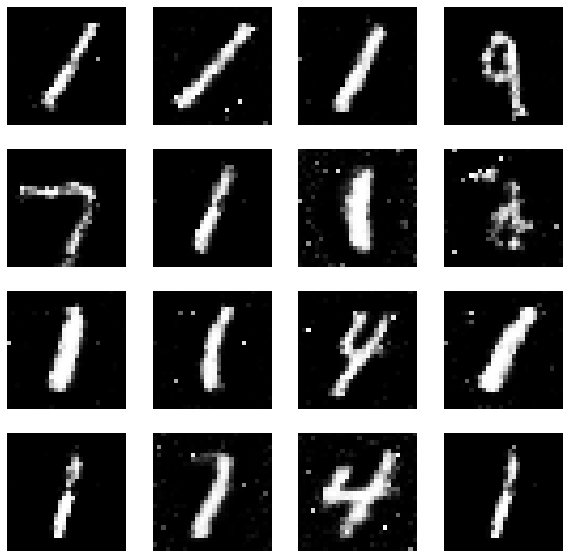

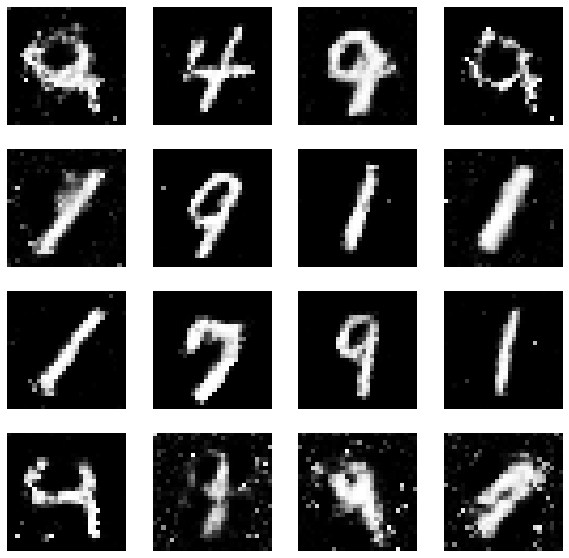

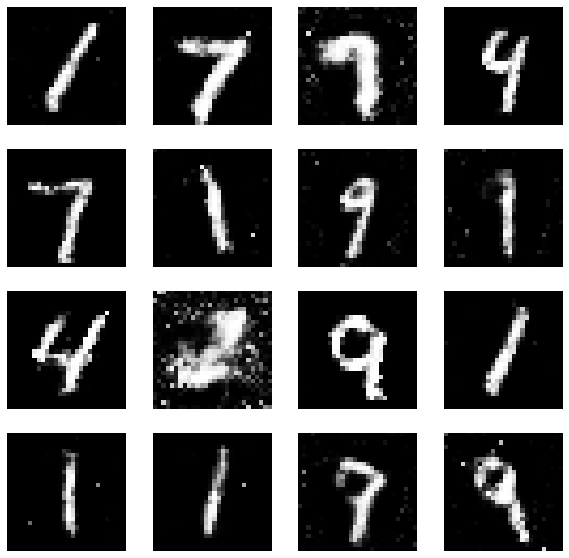

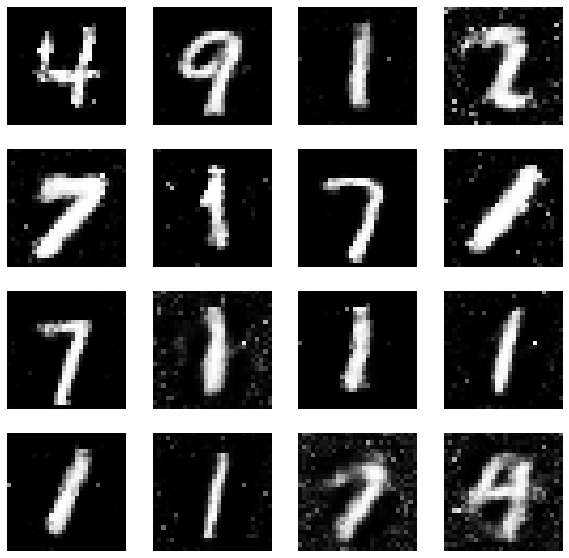

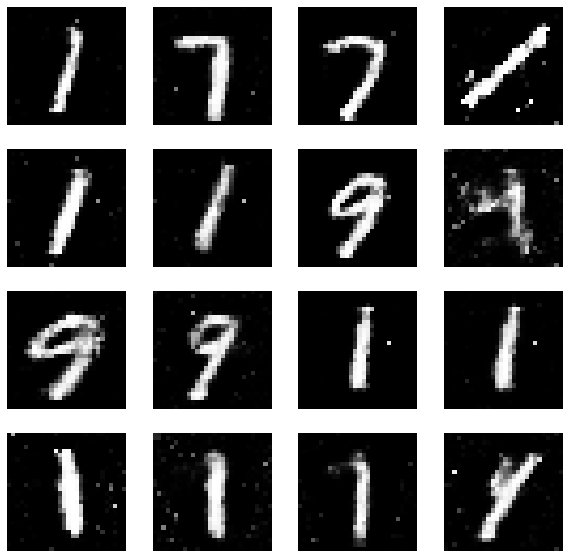

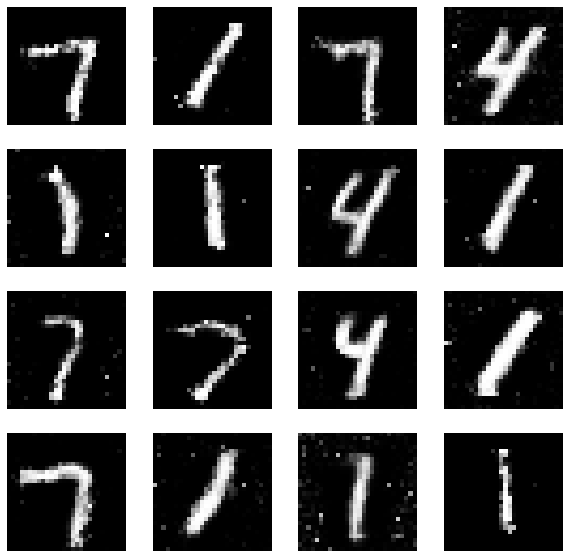

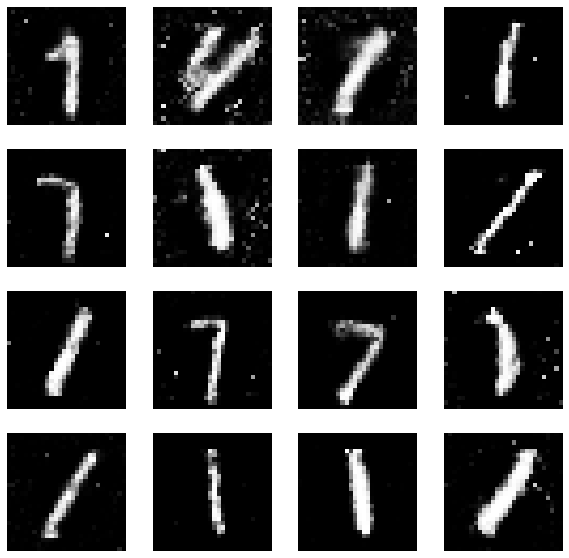

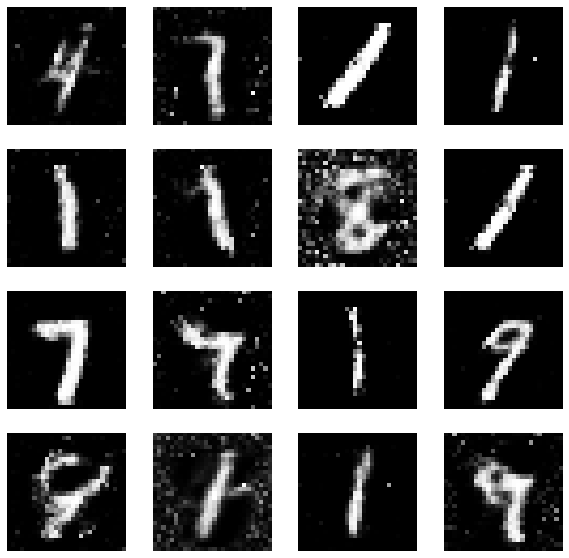

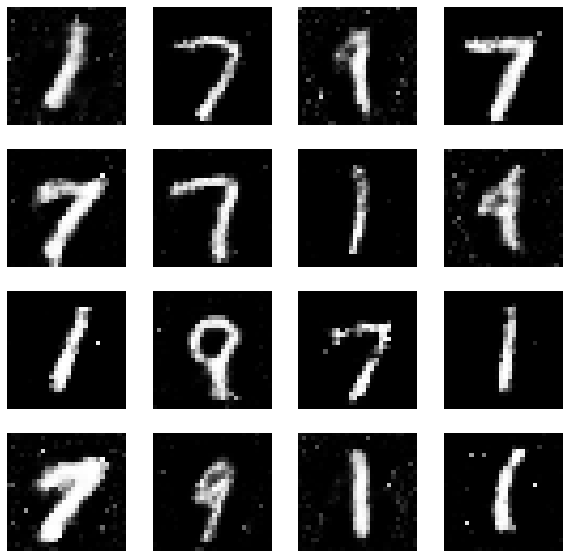

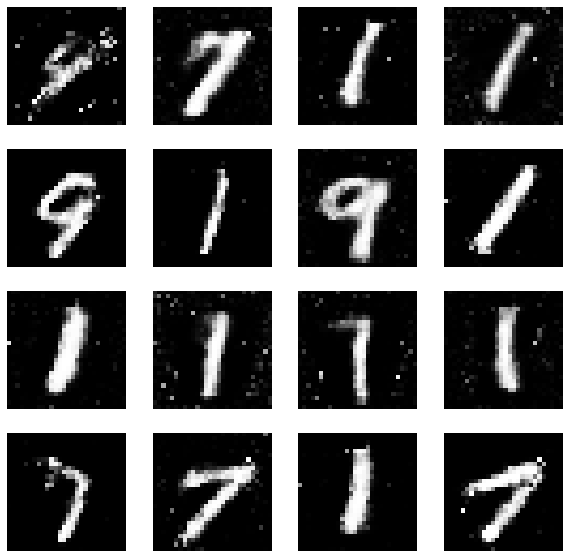

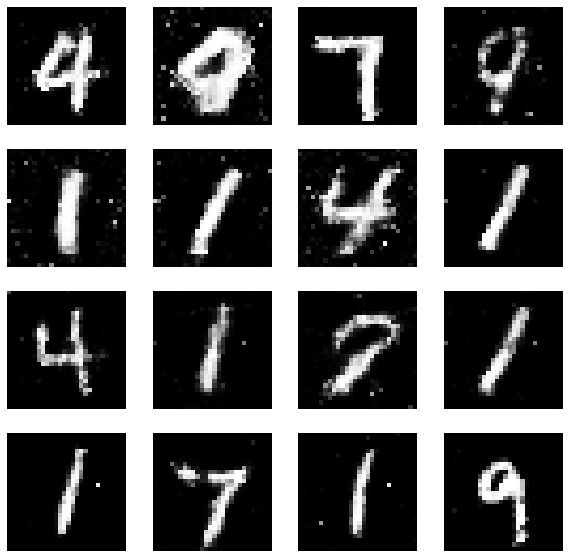

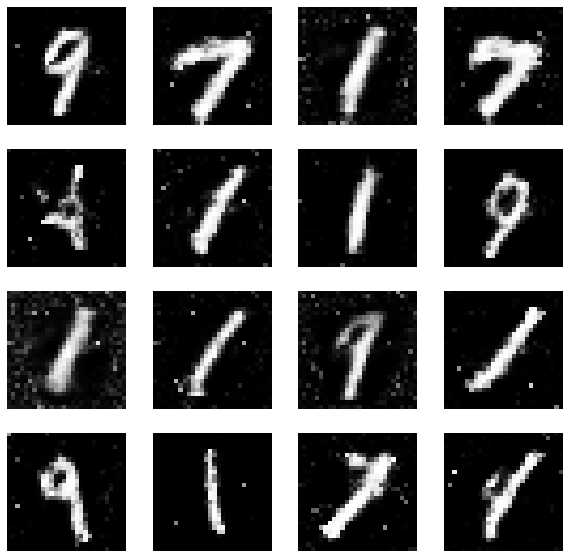

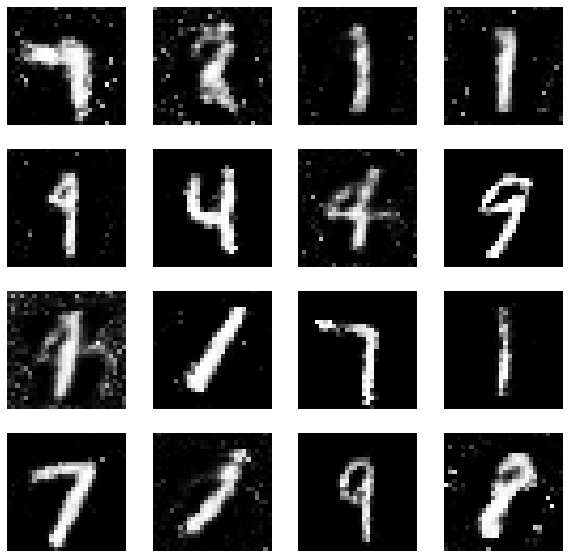

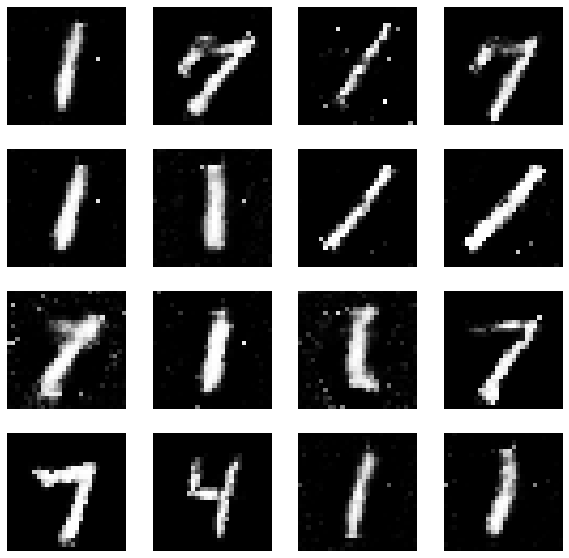

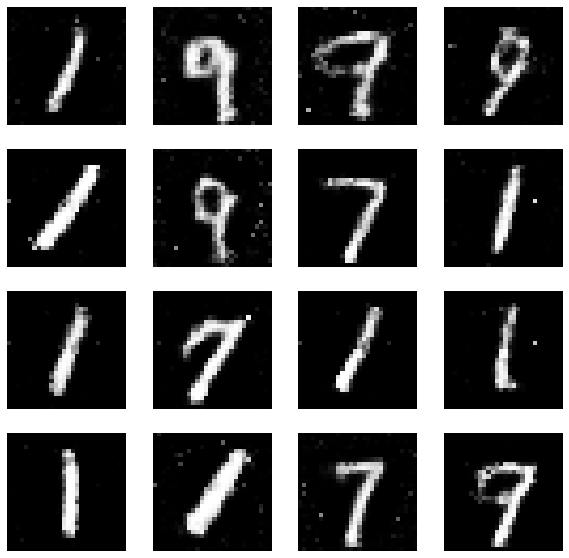

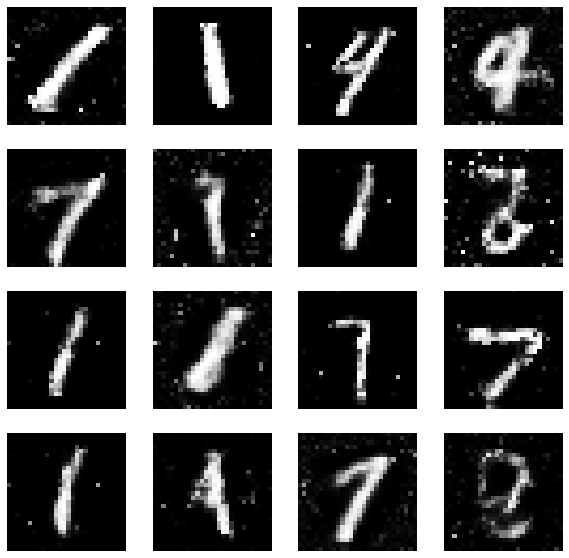

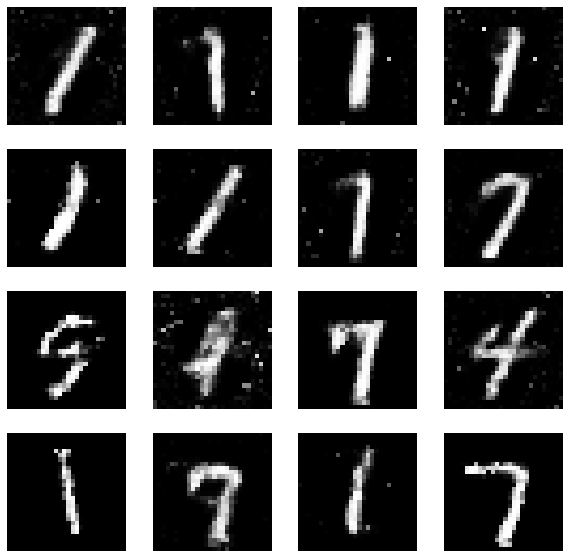

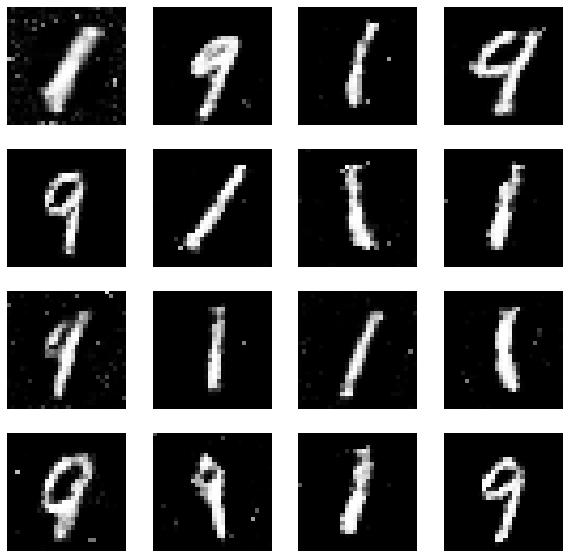

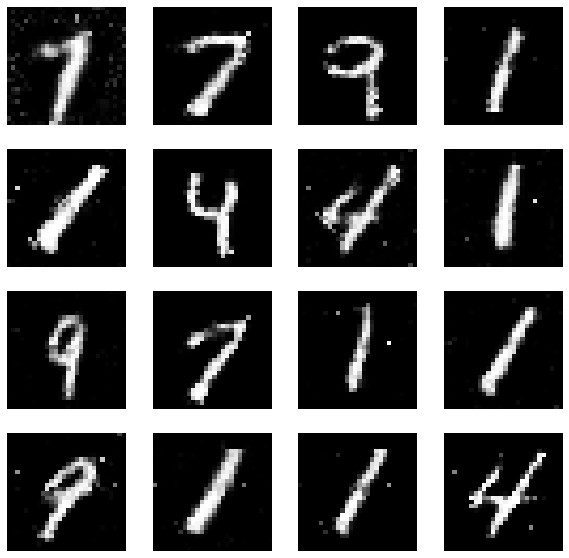

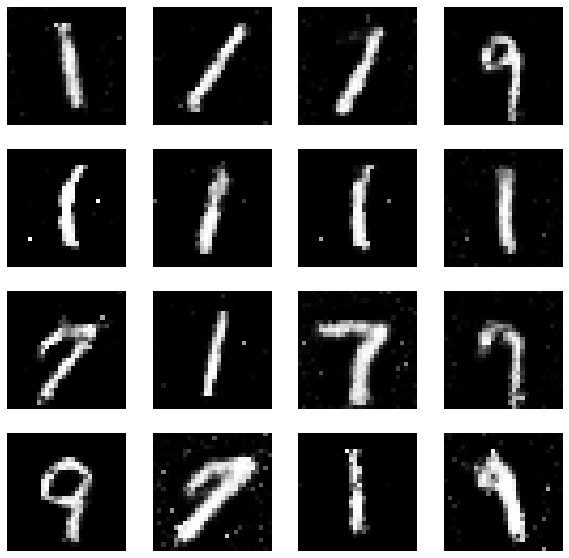

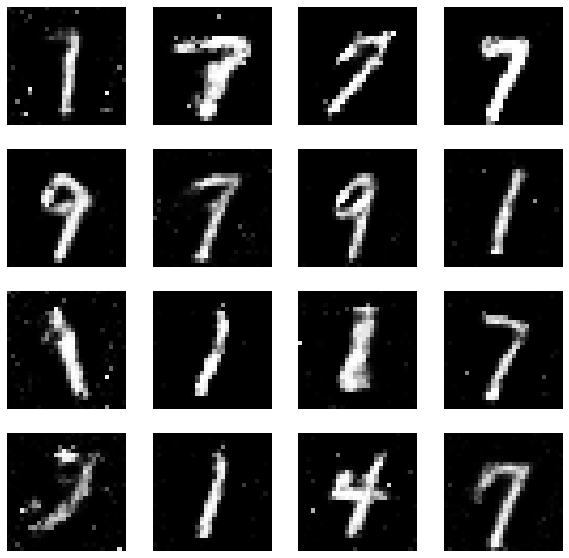

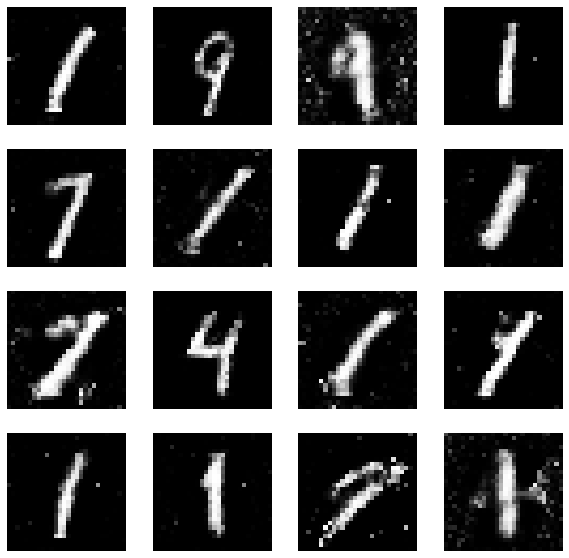

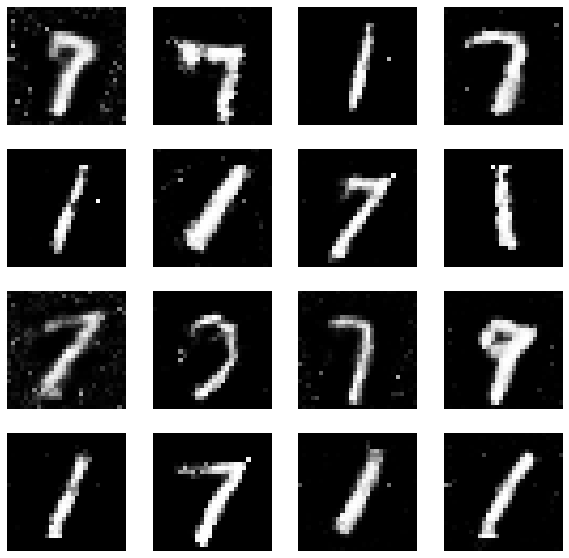

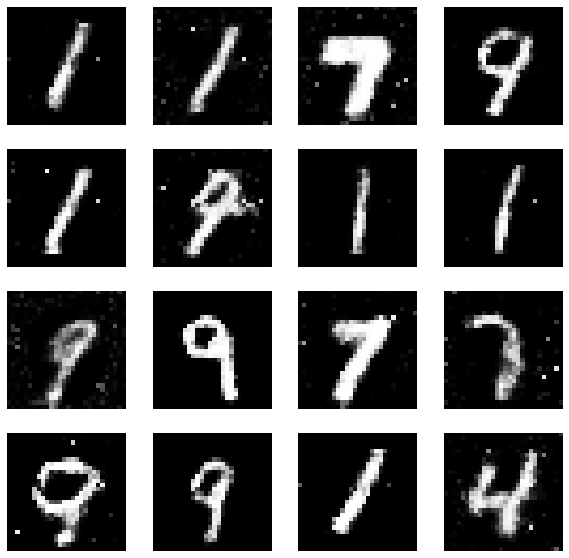

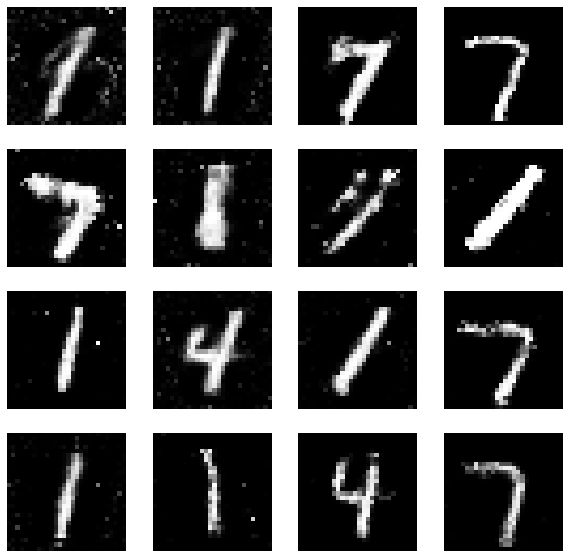

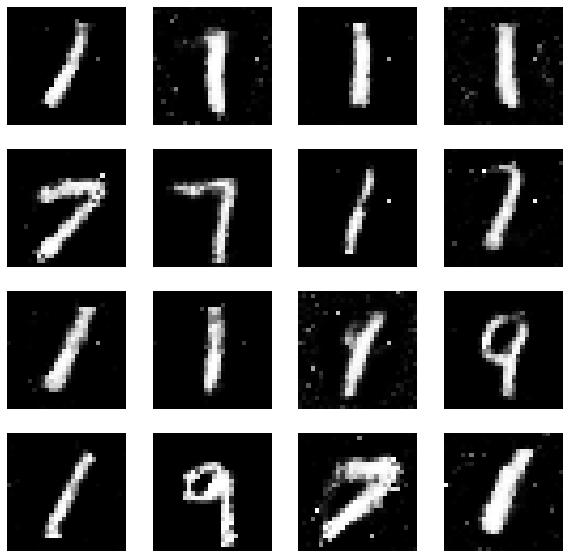

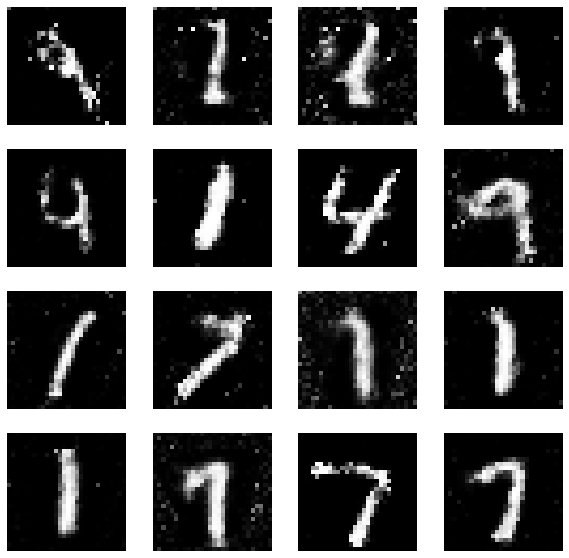

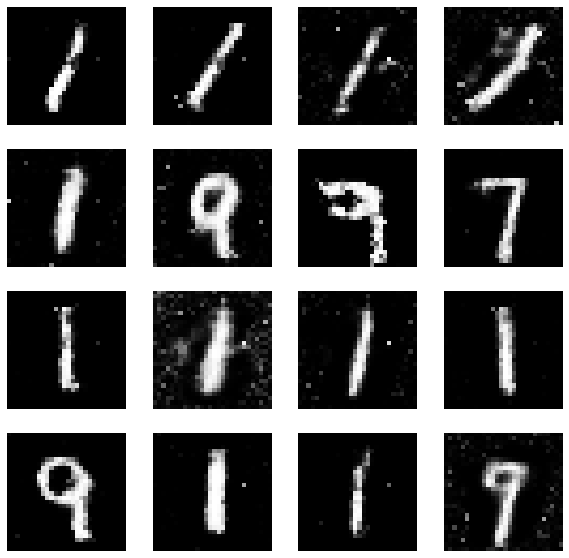

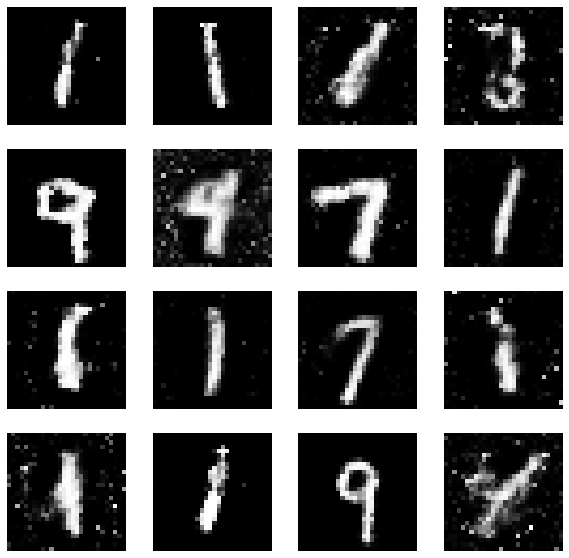

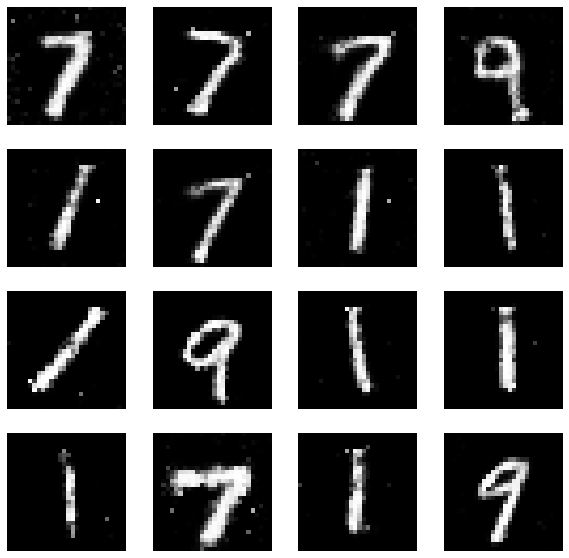

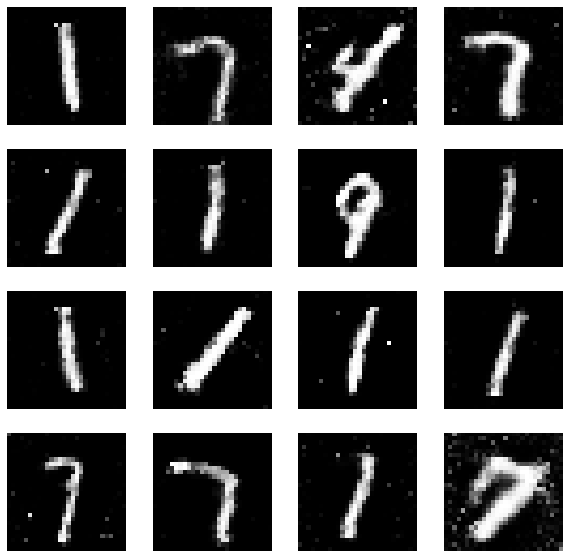

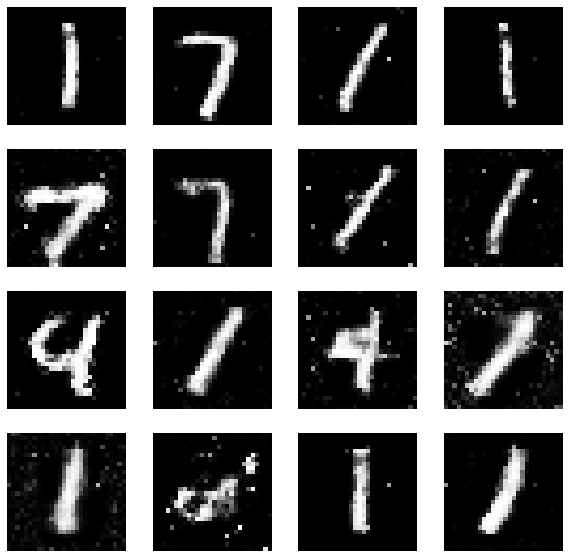

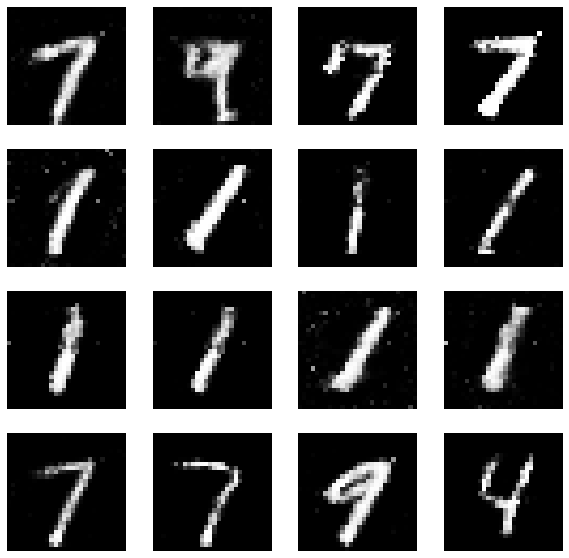

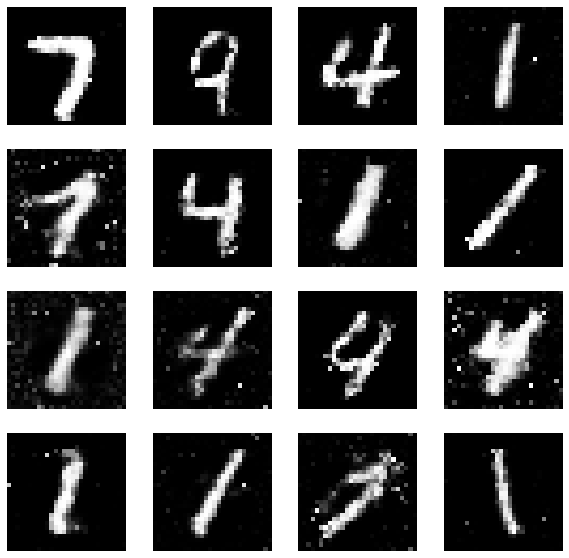

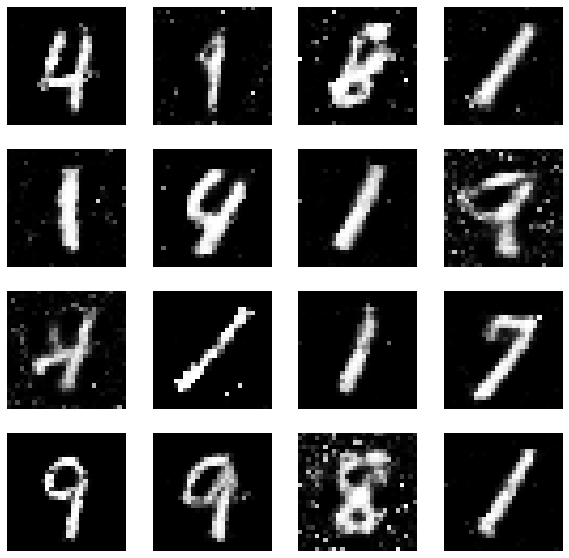

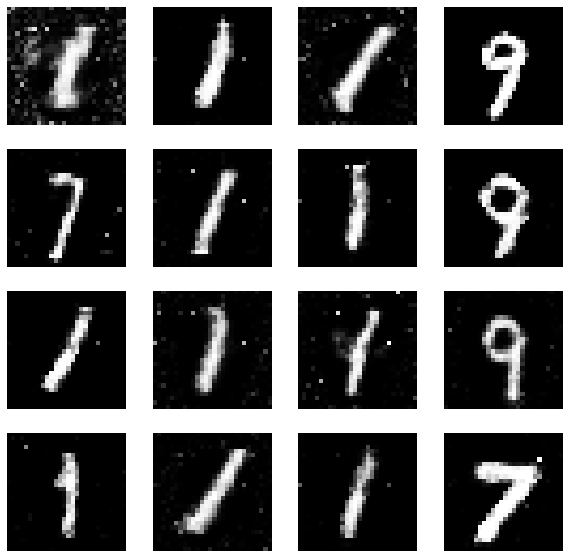

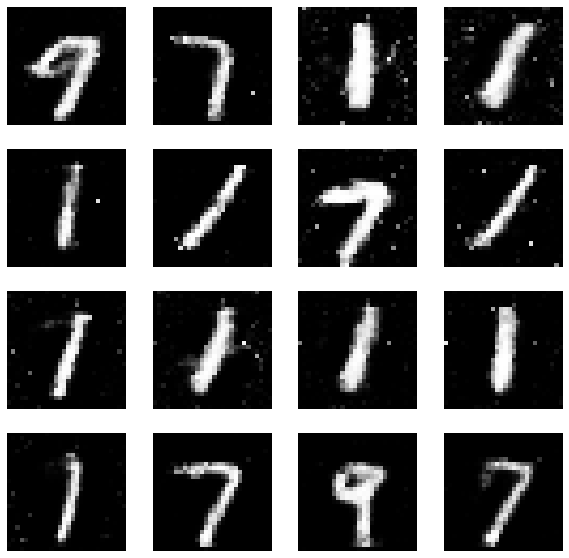

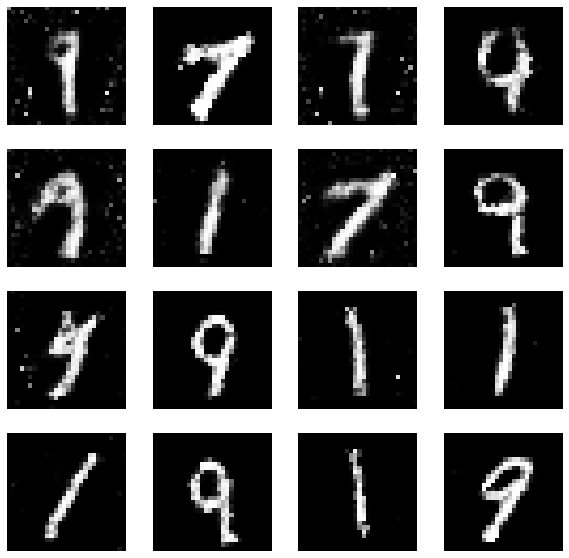

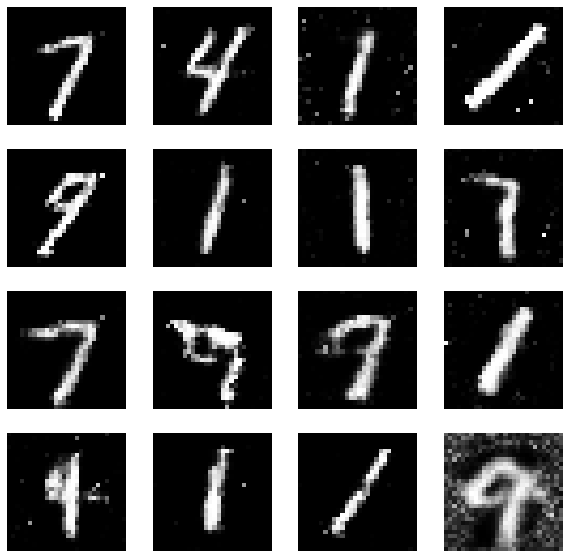

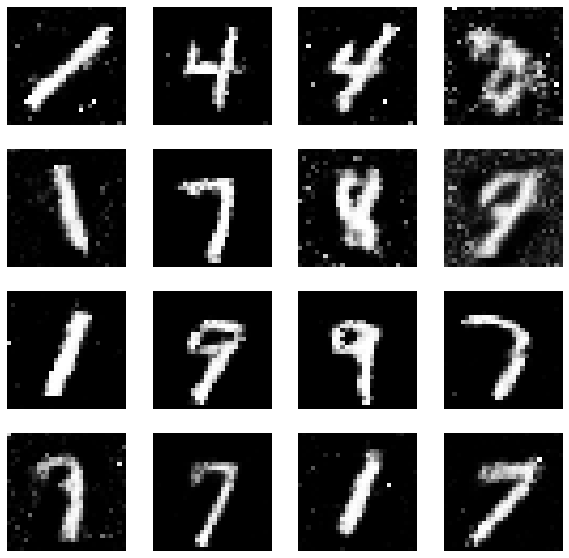

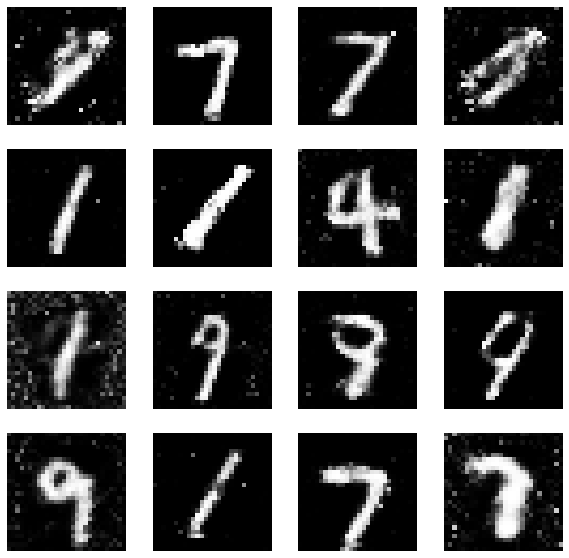

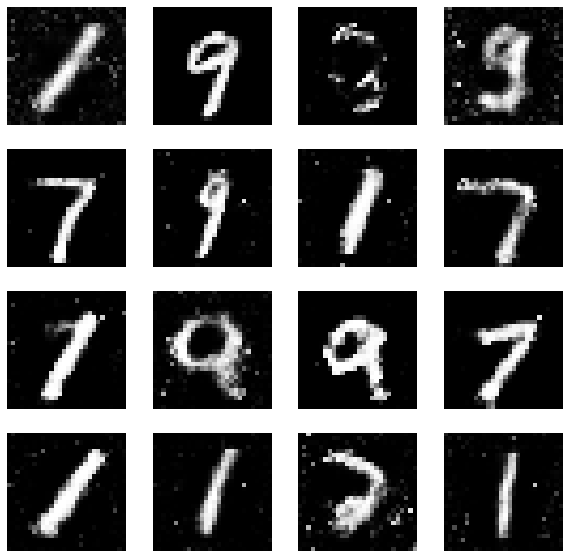

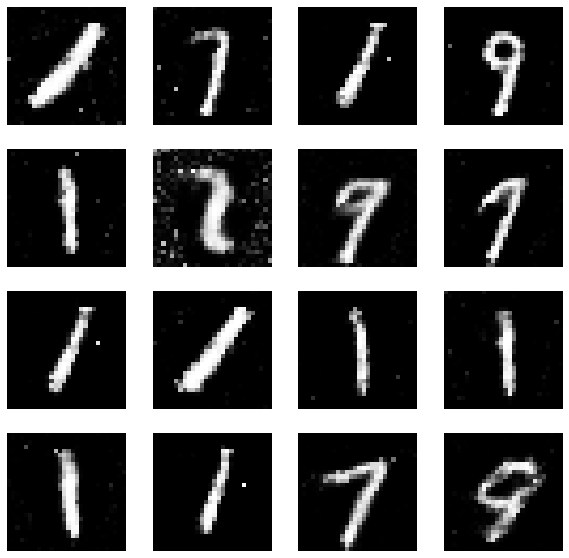

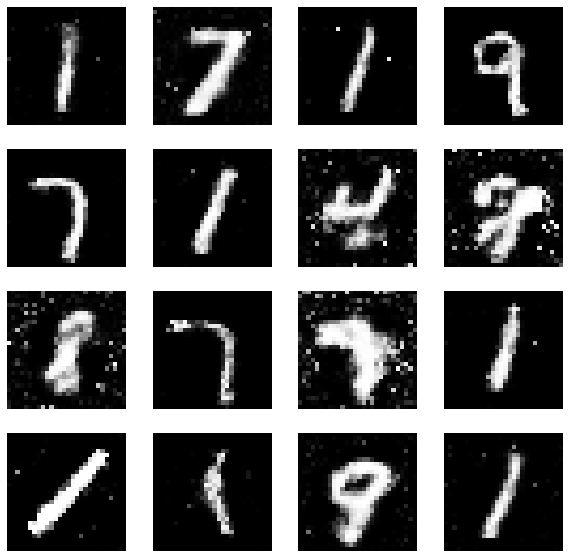

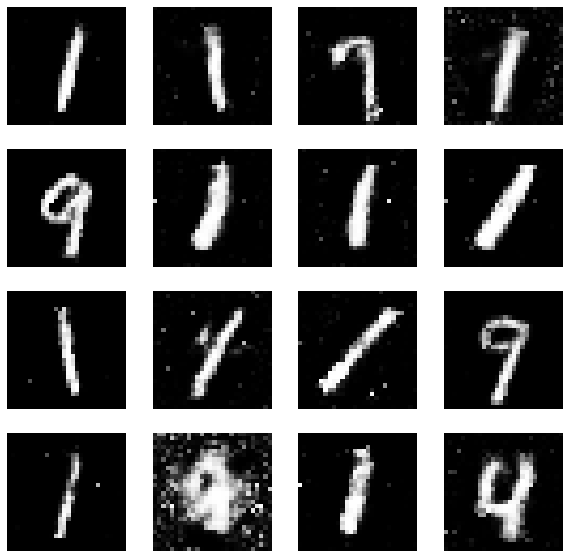

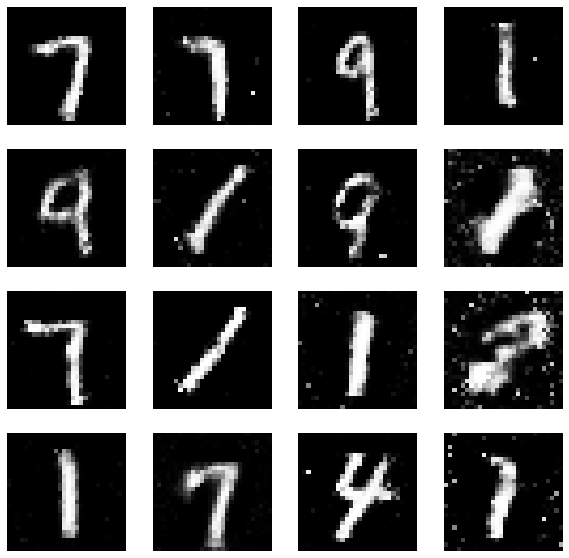

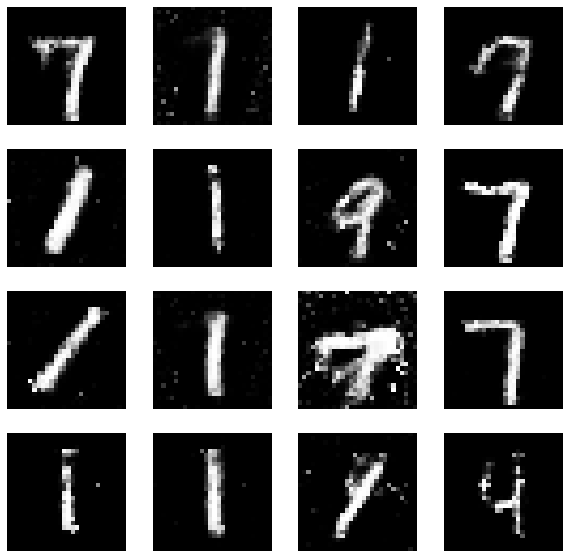

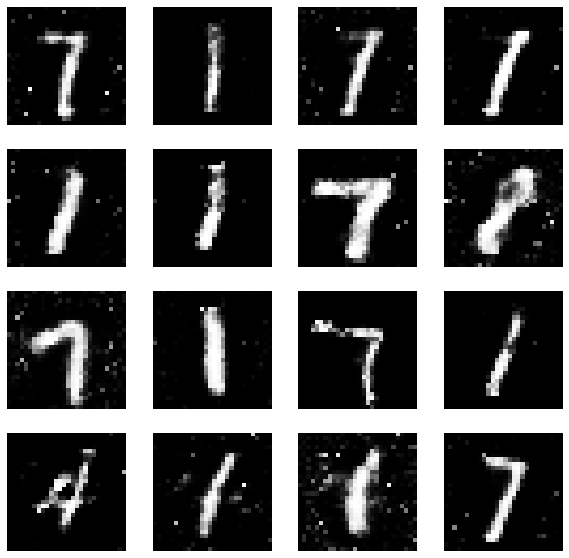

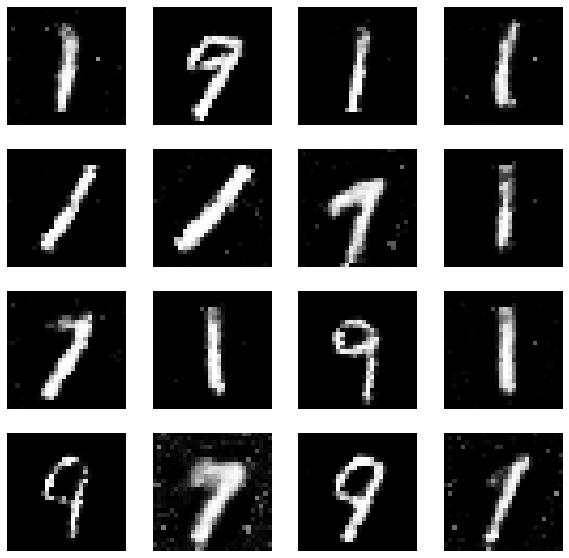

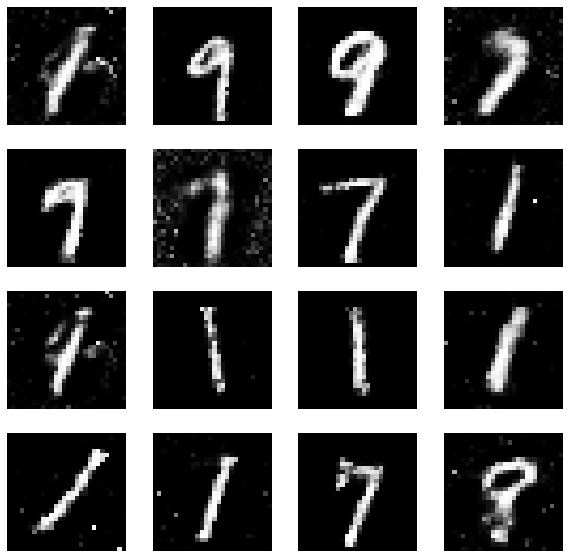

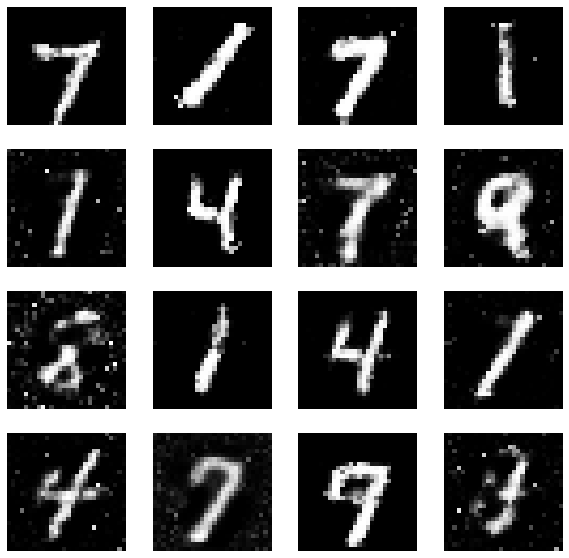

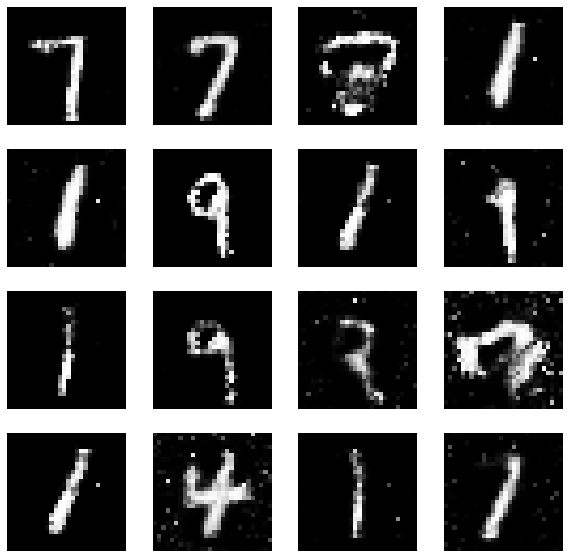

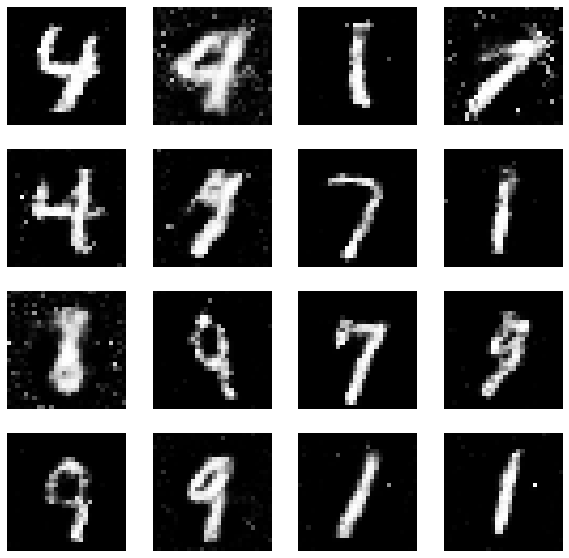

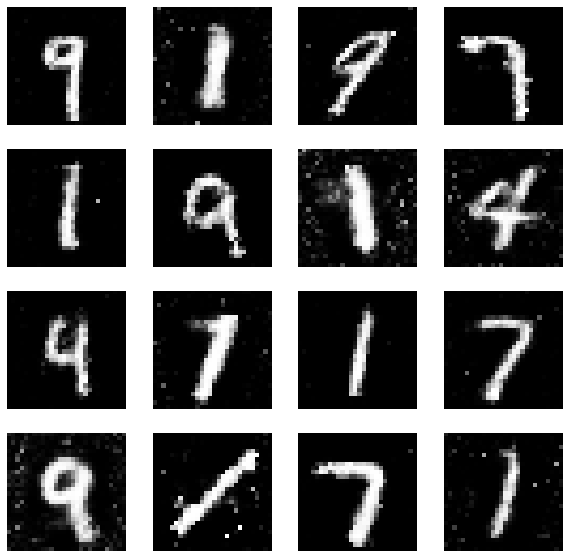

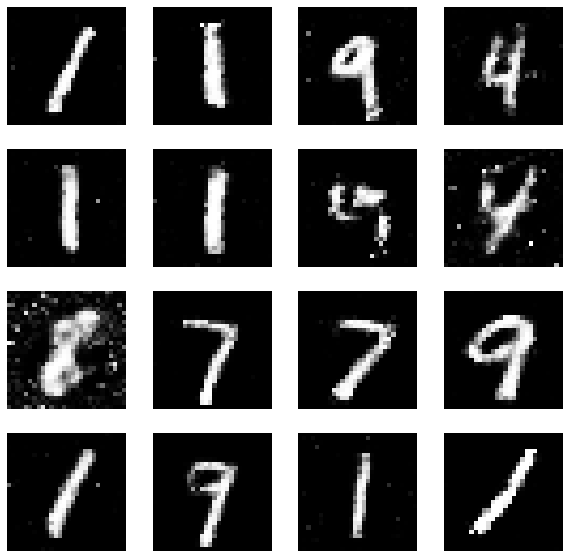

Error in callback <function flush_figures at 0x000001EB4122F670> (for post_execute):


KeyboardInterrupt: 

In [15]:
if __name__ == '__main__':
  train_dcgan(train_continue = True)